/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


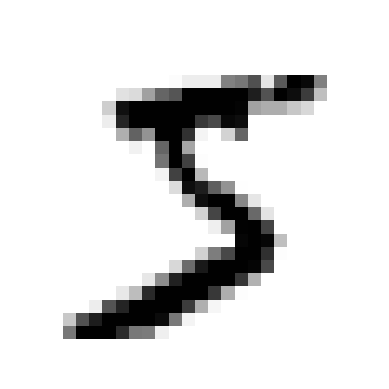

[[53892   687]
 [ 1891  3530]]
0.8370879772350012
0.6511713705958311
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=  22.5s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=  21.5s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  21.5s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=  22.4s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=  21.2s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  21.7s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=  21.9s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  20.9s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=  22.2s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=  22.1s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

X, y =mnist["data"], mnist["target"]

import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

import numpy as np

y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]      #MNIST데이터셋은 이미 훈련데이터와 테스트데이터가 나뉘어져있음

#이진 분류기(손글씨중 숫자 5인지만 맞추기)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

#교차검증 직접구현
'''
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))
'''
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)         #F1점수 -> 조화평균

y_scores = sgd_clf.decision_function([some_digit])

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method = "decision_function")      #결정점수 반환

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
'''
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend(loc="center right", fontsize=16)
  plt.xlabel("Threshold", fontsize=16)
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

def plot_precision_recall(precisions, recalls):
  plt.plot(thresholds, precisions[:-1], "b-")
  plt.legend(loc="center right", fontsize=16)
  plt.xlabel("Recall", fontsize=16)
  plt.ylabel("Precision", fontsize=16)
  plt.grid(True)
  plt.axis([0, 1, 0, 1])
plot_precision_recall(precisions, recalls)
plt.show()
'''
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

some_digit_scores = svm_clf.decision_function([some_digit])

from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

sgd_clf.decision_function([some_digit])

#다중 레이블 분류
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)